In [37]:
import torch
import pandas as pd
import os
from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision.transforms import v2

bean_annotations = pd.read_csv("data/beans.csv")
bean_annotations.head()
DEFECT_CLASSES = dict(
    [
        (defect, index)
        for (index, defect) in enumerate(pd.unique(bean_annotations["defect_class"]))
    ]
)
DEFECT_CLASSES


transforms = {
    "train": v2.Compose(
        [
            v2.Resize(size=(400, 400)),
            v2.RandomHorizontalFlip(),
            v2.RandomRotation(
                degrees=180, fill=(255, 255, 255)
            ),  # Augment the data with random rotations, setting the background to white
            v2.ToDtype(
                torch.float32, scale=True
            ),  # Use float32 datatype to enable training on Apple silicon GPU
            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    ),
    "test": v2.Compose(
        [
            v2.Resize(size=(400, 400)),
            v2.RandomRotation(
                degrees=180, fill=(255, 255, 255)
            ),  # Augment the data with random rotations, setting the background to white
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    ),
}

In [38]:
class RoastDefectsDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.bean_annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.bean_annotations)

    def get_labels(self):
        return self.bean_annotations["defect_class"]

    def __getitem__(self, item):
        if torch.is_tensor(item):
            item = item.toList()

        img_name = self.bean_annotations.iloc[item, 0]
        img_dir = "-".join(img_name.split("-")[0:4])
        img_path = os.path.join(self.root_dir, img_dir, img_name)
        image = read_image(img_path)

        if self.transform:
            image = self.transform(image)

        annotations = DEFECT_CLASSES[
            self.bean_annotations.iloc[item, 1:]["defect_class"]
        ]
        return image, annotations

In [39]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(
    bean_annotations,
    train_size=0.8,
    random_state=42,  # for repeatability
    stratify=bean_annotations["defect_class"],
)

In [40]:
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchsampler import ImbalancedDatasetSampler

data_train = RoastDefectsDataset(
    csv_file="data/beans.csv",
    root_dir="data/processed-whitebg",
    transform=transforms["train"],
)

data_test = RoastDefectsDataset(
    csv_file="data/beans.csv",
    root_dir="data/processed-whitebg",
    transform=transforms["test"],
)

train_sampler = ImbalancedDatasetSampler(
    data_train, labels=train["defect_class"], indices=list(train.index)
)
test_sampler = SubsetRandomSampler(list(test.index))


train_loader = DataLoader(data_train, sampler=train_sampler, batch_size=4)
test_loader = DataLoader(data_test, sampler=test_sampler, batch_size=1)

dataloaders = {"test": test_loader, "train": train_loader}
dataset_sizes = {"test": len(test), "train": len(train)}

In [76]:
device = "mps"

In [77]:
from sklearn.metrics import classification_report


def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs - 1}")
        print("-" * 10)

        # Each epoch has a training and validation phase
        for phase in ["train", "test"]:
            if phase == "train":
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            all_labels = []
            all_preds = []

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                all_labels.extend(labels.tolist())

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    all_preds.extend(preds.tolist())

                    # backward + optimize only if in training phase
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == "train":
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            print(f"Correct guesses in phase {phase}: {running_corrects}")
            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
            if phase == "test":
                print("Classification report for test dataset:")
                print(
                    classification_report(
                        all_labels,
                        all_preds,
                        target_names=DEFECT_CLASSES.keys(),
                        zero_division=0,
                    )
                )
            print()
    return model

In [112]:
import torch
import torchvision

model = torchvision.models.mobilenet_v2()
model_classifier_in_features = model.classifier[1].in_features
model.classifier[1] = torch.nn.Linear(model_classifier_in_features, len(DEFECT_CLASSES))
model

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [113]:
class_weights = torch.tensor(
    [
        len(bean_annotations)
        / len(bean_annotations[bean_annotations["defect_class"] == defect])
        for defect in DEFECT_CLASSES.keys()
    ]
).to(device)

In [116]:
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn as nn


model.to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1, weight=class_weights)

optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

In [117]:
model_ft = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=40)

Epoch 0/39
----------
Correct guesses in phase train: 856
train Loss: 2.8939 Acc: 0.3842
Correct guesses in phase test: 32
test Loss: 4.1197 Acc: 0.0573
Classification report for test dataset:
              precision    recall  f1-score   support

       burnt       0.01      0.10      0.01        10
      normal       0.67      0.02      0.03       263
        frag       0.11      0.08      0.10        59
       under       0.06      1.00      0.12        21
      quaker       1.00      0.01      0.01       196
insectOrMold       0.00      0.00      0.00         9

    accuracy                           0.06       558
   macro avg       0.31      0.20      0.04       558
weighted avg       0.68      0.06      0.03       558


Epoch 1/39
----------
Correct guesses in phase train: 942
train Loss: 2.8291 Acc: 0.4228
Correct guesses in phase test: 304
test Loss: 3.0884 Acc: 0.5448
Classification report for test dataset:
              precision    recall  f1-score   support

       burnt  

<Axes: >

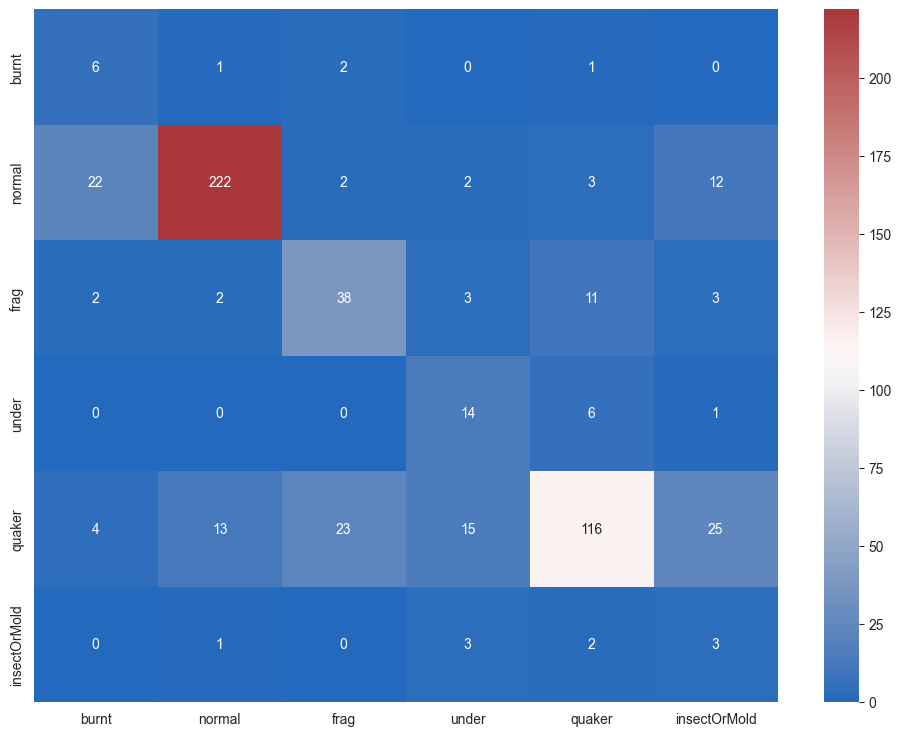

In [118]:
from torcheval.metrics import MulticlassConfusionMatrix
import seaborn as sns
import matplotlib.pyplot as plt

model_ft.eval()
all_labels = []
all_preds = []
with torch.no_grad():
    for inputs, labels in dataloaders["test"]:
        inputs = inputs.to(device)
        labels = labels.to(device)
        all_labels.extend(labels.tolist())
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.tolist())

matrix = MulticlassConfusionMatrix(len(DEFECT_CLASSES))
matrix.update(torch.tensor(all_preds), torch.tensor(all_labels))

confs = matrix.compute()

fig, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(
    confs,
    annot=True,  # write values in cells
    cmap="vlag",
    xticklabels=DEFECT_CLASSES.keys(),
    yticklabels=DEFECT_CLASSES.keys(),
    ax=ax,
    fmt="g",  # annotate without using scientific notation
)

# plt.savefig("trained-models/confusion-matrices/shufflenet-no-pretraining0-5gamma.png")

In [83]:
# torch.save(model_ft.state_dict(), "trained-models/shuffleNet-no-pretraining0-5gamma.pt")